In [1]:
import os
# VERSION = 9
# if VERSION is not None:
#     os.environ["CC"] = f"/usr/bin/gcc-{VERSION}"
#     os.environ["CXX"] = f"/usr/bin/g++-{VERSION}"
from pathlib import Path
import sys
sys.path.insert(0, str(Path(os.path.abspath('')).parent))
print(str(Path(os.path.abspath('')).parent))
import math
import torch
import matplotlib.pyplot as plt
import mediapy
from icecream import ic
from data import loader
import random
import time
from tqdm import tqdm
import numpy as np
from utils import cam_util
from utils.train_util import *
from models.ingp_color import Model, TetOptimizer
from fused_ssim import fused_ssim
from pathlib import Path, PosixPath
from utils.args import Args
import pickle
import json
from utils import safe_math
from delaunay_rasterization.internal.render_err import render_err
from utils.train_util import render
import imageio

device = torch.device("cuda")
args = lambda x: x
args.dataset_path = Path("/data/nerf_datasets/360/bicycle")
args.output_path = Path("output/test/")
args.image_folder = "images_4"
args.tile_size = 16
args.lambda_ssim = 0.0

train_cameras, test_cameras, scene_info = loader.load_dataset(
    args.dataset_path, args.image_folder, data_device="cuda", eval=True)

cmap = plt.get_cmap("jet")
path = Path(os.path.abspath('')).parent / "output/bicycle_low_init"
model = Model.load_ckpt(path, device)
torch.cuda.empty_cache()
# model = Model.load_ply(path, device)
camera = train_cameras[8]
target = camera.original_image.cuda()

/home/amai/delaunay_splatting


/home/amai/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/home/amai/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/home/amai/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
/home/amai/.local/lib/python3.11/site-packages/torch/utils/cpp_extension.py:2059: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for co

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
Reading camera 194/194
Loaded Train Cameras: 169
Loaded Test Cameras: 25
Loaded 53706 vertices


In [2]:
with torch.no_grad():
    render_pkg = render(camera, model)

/home/amai/.local/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [3]:

def disp(im):
    im = (im.detach().cpu().numpy() * 255).clip(min=0, max=255).astype(np.uint8)
    plt.imshow(im)
    plt.show()


with torch.no_grad():
    tet_rgbs_grad, render_pkg2 = render_err(target, camera, model, tile_size=args.tile_size, lambda_ssim=args.lambda_ssim)
    # tet_rgbs_grad = update_rgbs(tet_rgbs_grad, tet_grad, render_pkg['tet_area'])

/home/amai/.local/lib/python3.11/site-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


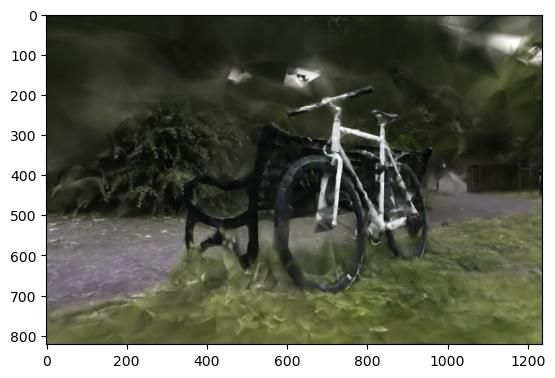

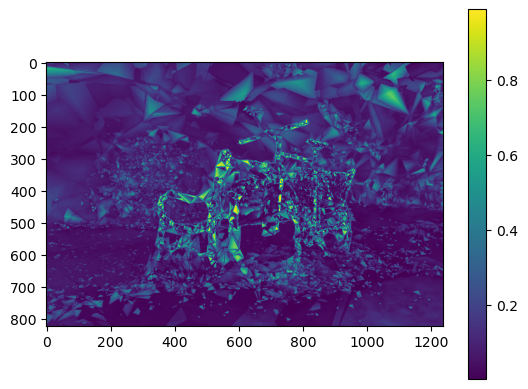

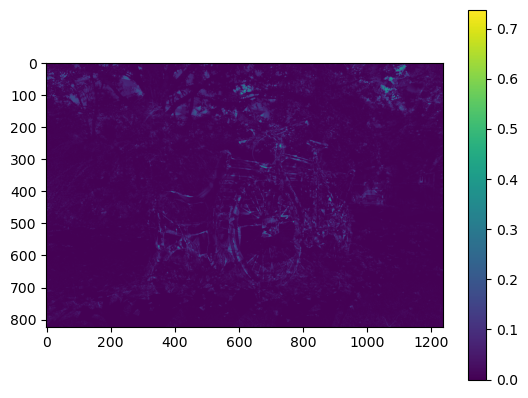

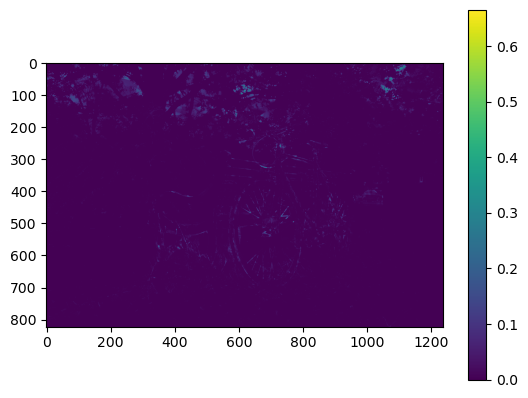

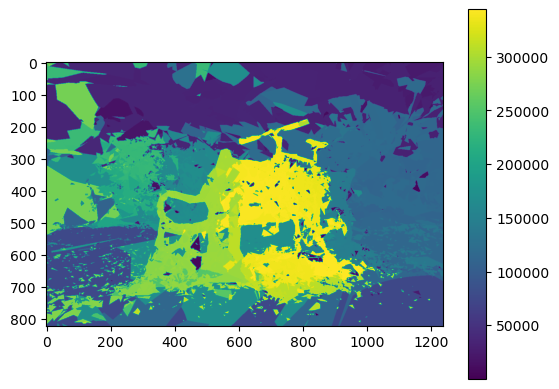

In [4]:
disp(render_pkg['render'].permute(1, 2, 0))
plt.imshow(render_pkg2['debug_img'][:, :, 0].detach().cpu().numpy())
plt.colorbar()
plt.show()
plt.imshow(render_pkg2['debug_img'][:, :, 1].detach().cpu().numpy())
plt.colorbar()
plt.show()
plt.imshow(render_pkg2['debug_img'][:, :, 2].detach().cpu().numpy())
plt.colorbar()
plt.show()
plt.imshow(render_pkg2['debug_img'][:, :, 3].detach().cpu().numpy())
plt.colorbar()
plt.show()

tensor(232, device='cuda:0') tensor(344000, device='cuda:0')


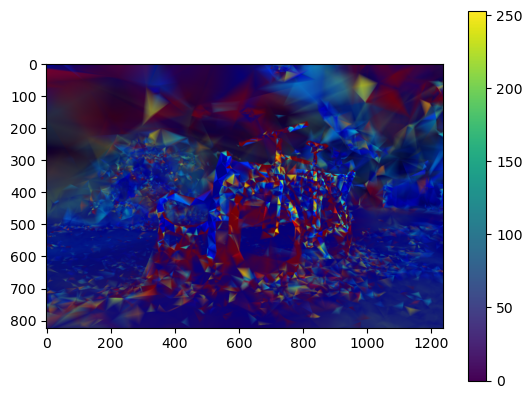

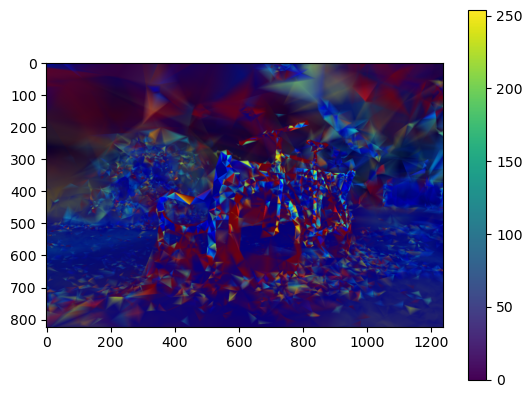

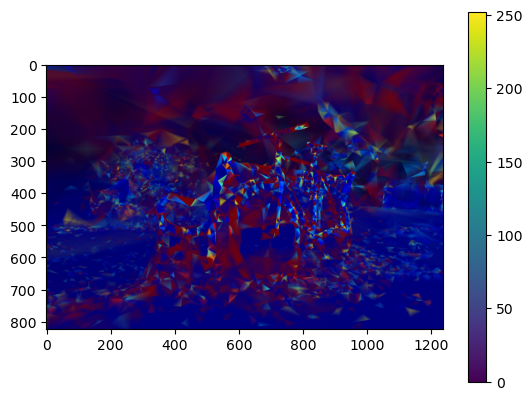

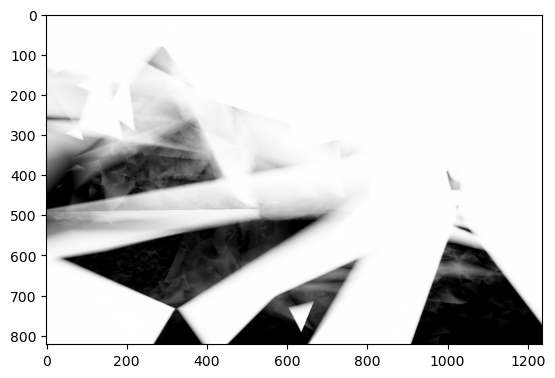

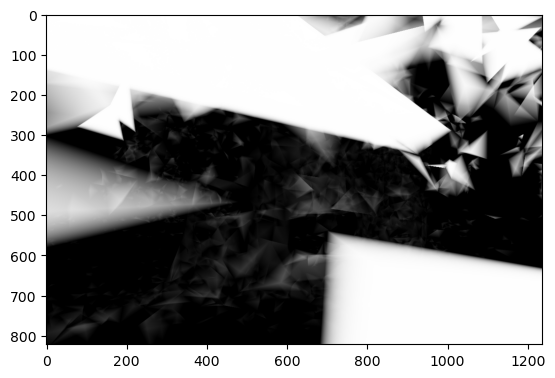

In [21]:
MTC = 50000
s0 = tet_rgbs_grad[:, 0]
s1 = tet_rgbs_grad[:, 1]
s2 = tet_rgbs_grad[:, 2]
avg_alpha = (s0 / render_pkg2['tet_count'].clip(min=1)).reshape(-1, 1)
split_mu = safe_math.safe_div(s1, s0)
split_std = safe_math.safe_div(s2, s0) - split_mu**2
split_std[s0 < 1e-5] = 0
# split_vote = split_std.reshape(-1, 1) * avg_alpha.reshape(-1, 1)
print((render_pkg2['tet_count'] > MTC).sum(), (render_pkg2['tet_count'] < MTC).sum())
split_std[render_pkg2['tet_count'] > MTC] = 0
image = render_debug(split_mu.reshape(-1, 1)**2, model, camera)
plt.imshow(image)
plt.colorbar()
plt.show()
image = render_debug(safe_math.safe_div(s2, s0).reshape(-1, 1), model, camera)
plt.imshow(image)
plt.colorbar()
plt.show()
# image = render_debug(s1.reshape(-1, 1), model, camera)
# plt.imshow(image)
# plt.colorbar()
# plt.show()
# image = render_debug(s2.reshape(-1, 1), model, camera)
# plt.imshow(image)
# plt.colorbar()
# plt.show()
image = render_debug(split_std.reshape(-1, 1), model, camera)
plt.imshow(image)
plt.colorbar()
plt.show()
# clone_mask = split_std > 1e-2
# f = clone_mask.float().reshape(-1, 1).expand(-1, 4)
# # f[:, 3] = split_std * 1000
# binary_im = render_debug(f, model, camera)
# plt.imshow(binary_im)
# plt.show()

# clone_mask = render_pkg2['tet_count'] < MTC
# print(clone_mask.sum(), render_pkg2['tet_count'].float().mean())
# f = clone_mask.float().reshape(-1, 1).expand(-1, 4)
# binary_im = render_debug(f, model, camera)
# plt.imshow(binary_im)
# plt.show()
clone_mask = split_std > 1e-10
f = clone_mask.float().reshape(-1, 1).expand(-1, 4)
# f[:, 3] = 10*avg_alpha.reshape(-1)
binary_im = render_debug(f, model, camera)
plt.imshow(binary_im)
plt.show()

clone_mask = split_vote > 1e-4
f = clone_mask.float().reshape(-1, 1).expand(-1, 4)
# f[:, 3] = 10*avg_alpha.reshape(-1)
binary_im = render_debug(f, model, camera)
plt.imshow(binary_im)
plt.show()

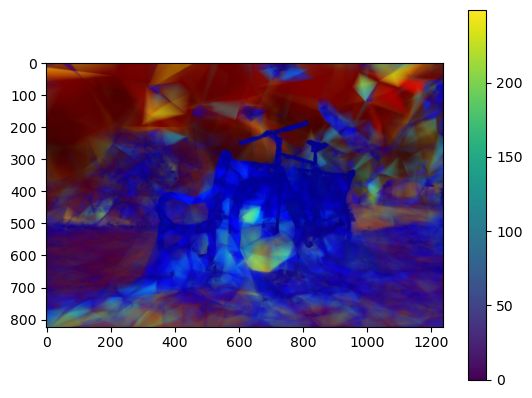

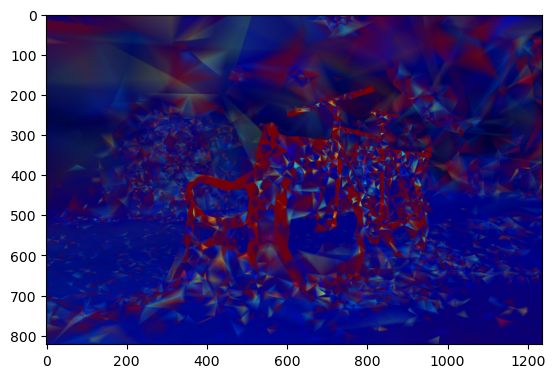

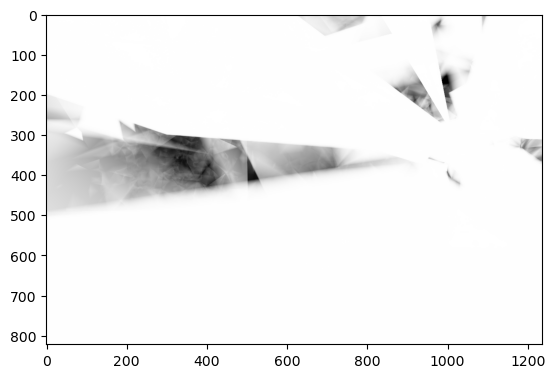

In [6]:
binary_im = render_debug(render_pkg2['tet_count'].float().reshape(-1, 1), model, camera)
plt.imshow(binary_im)
plt.colorbar()
plt.show()

binary_im = render_debug(avg_alpha, model, camera)
plt.imshow(binary_im)
plt.show()
clone_mask = avg_alpha > 1e-3
f = clone_mask.float().reshape(-1, 1).expand(-1, 4)
# f[:, 3] = 10*avg_alpha.reshape(-1)
binary_im = render_debug(f, model, camera)
plt.imshow(binary_im)
plt.show()

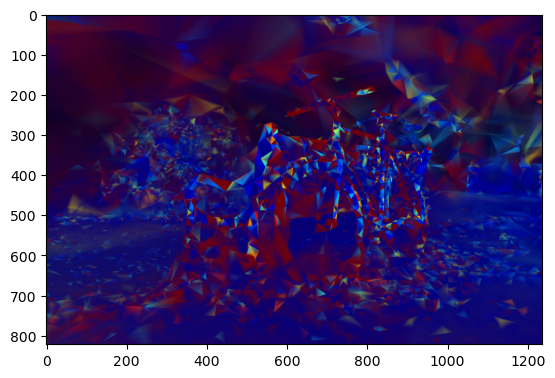

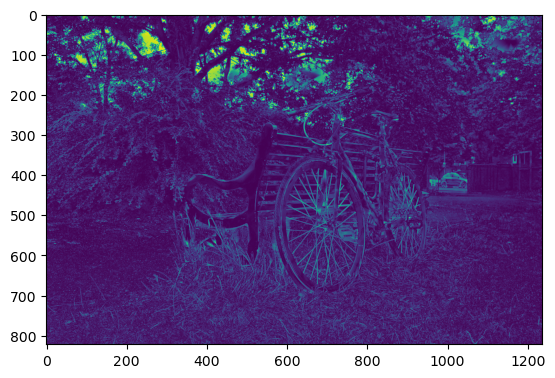

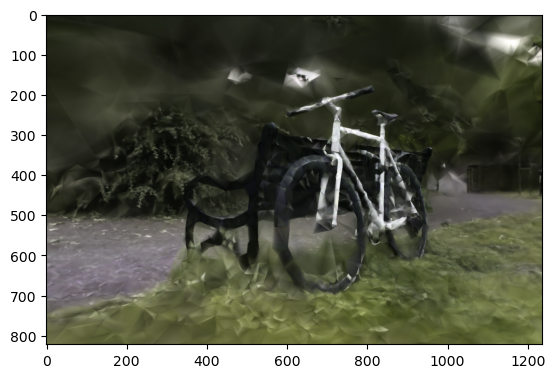

In [7]:
image = render_debug(split_std.reshape(-1, 1), model, camera)
plt.imshow(image)
plt.show()
disp(render_pkg2['pixel_err'])
disp(render_pkg2['render_img'].permute(1, 2, 0))
